In [2]:
%pip install pyagrum
%load_ext autoreload
%autoreload 2

import csv
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import re
import itertools
from os import path
from model import *


You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


  Using cached pyAgrum-0.22.9-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached matplotlib-3.5.1-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init csv and data

In [3]:
VERTICES_FILE = "VERTICES.CSV"
ARCS_FILE = "ARCS.CSV"
TID_FILE = "thid.csv"
SC_ASSOCIATION_FILE = "scAssociation.csv"
IS_SIMPLIFIED = True
import re


class Vertex:
  def __init__(self, id, text, type,  number):
    self.id = str(id)
    self.text = text 
    self.type = type 
    self.number = number
    self.tid_id = None
    if self.is_tid():
      self.tid_id = self.extract_tid_id()

  def is_leaf(self):
    return self.type == "LEAF"

  def is_and(self):
    return self.type == "AND"

  def is_or(self):
    return self.type == "OR"

  def is_tid(self):
    return "tid" in self.text 

  def extract_tid_id(self):
      return re.sub("\(.*?\)", "", self.text)

  def is_final_tid(self):
    return self.tid_id == "tid17" or self.tid_id == "tid02"

  def __str__(self):
    return "id = {}, text = {}, type = {}".format(self.id, self.text, self.type)

  def find_by_id(vertices, v_id):
    for v in vertices:
      if v.id == v_id:
        return v.get_name()
    return None

  def find_by_threat_id(vertices, v_id):
    for v in vertices:
      if v.tid_id == v_id:
        return v.get_name()
    return None

  def get_threats(vertices):
      return [v for v in vertices if v.is_tid()]

  def get_name(self):
    return "{}-{}".format(self.id, self.text)

# class FinalSC:
#     def is_tid_final(id):
        # return id == 

## Folders that change depending on the threat model
def complete_folder(f):
  return path.join("complete", f)

def simplified_folder(f):
  return path.join("simplified", f)

# Data folder, with probabilities and other stuff
def folder_data(f):
  return path.join("data", f)




vertices = []
arcs = []
thidProb = {}
#dict containing p(v) of a node 
arcsDict = {}
#dict containing parents of a node 
invArcsDict = {}



def init_data(folder_fn):
  # Get vertices nodes
  with open(folder_fn(VERTICES_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      v = Vertex(row[0], row[1], row[2], row[3])
      vertices.append(v)
      
  # arc nodes extraction 
  with open(folder_fn(ARCS_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      [int(i) for i in row]
      arcs.append(row)
      if row[0] in invArcsDict.keys():
        invArcsDict[row[0]].append(row[1])
      else:
        invArcsDict[row[0]] = []
        invArcsDict[row[0]].append(row[1])
      arcsDict[row[1]] = row[-1]

  #prelievo informazioni delle thid prob
  with open(folder_data(TID_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      thidProb[row[0]] = float(row[-1])

#init_data(complete_folder)
if IS_SIMPLIFIED:
  init_data(simplified_folder)
else:
  init_data(complete_folder)


def multiplyList(myList) :
    # Multiply elements one by one
    result = 1
    for x in myList:
         result = result * x
    return result




FileNotFoundError: [Errno 2] No such file or directory: 'simplified\\VERTICES.CSV'

# Helper functions

# Bayesian Graph Generation


2
5
4
1
10
12
11
9
2
1
10
9


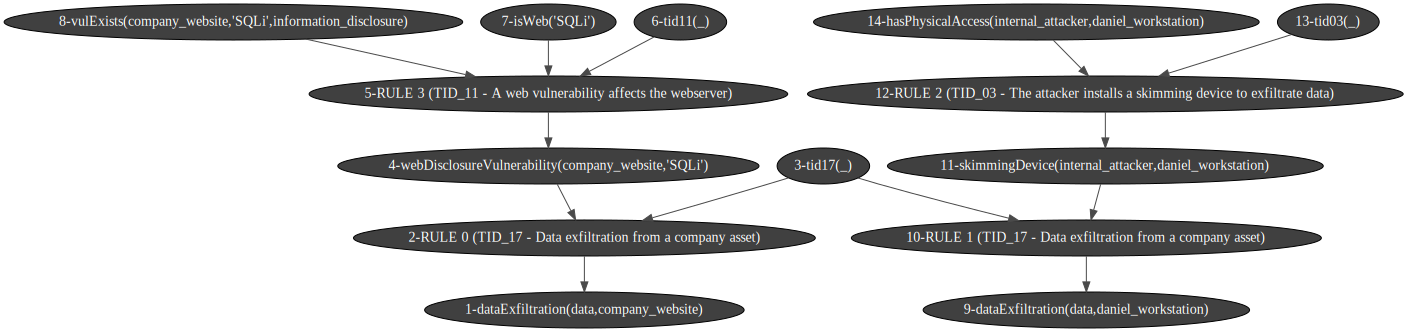

In [4]:
# Bayesian graph generation
bn = gum.BayesNet('BayesianThreatGraph')

# Arc and nodes population
for v in vertices:
  bn.add(gum.LabelizedVariable(v.get_name(), v.text, 2))
  # bn.add(gum.LabelizedVariable(v.id, v.text, 2))


for row in arcs:
  bn.addArc(Vertex.find_by_id(
      vertices, row[1]), Vertex.find_by_id(vertices, row[0]))

# cpt of leaf nodes
for v in vertices:
  if v.is_leaf():
    # cpt of tid nodes
    if v.is_tid():
      tid_id = v.extract_tid_id().upper().replace('TID', 'TID_')
      bn.cpt(v.get_name()).fillWith([1 - thidProb[tid_id], thidProb[tid_id]])
      arcsDict[v.id] = thidProb[tid_id]
    #TO DO assegnazione fittizia degli altri nodi
    else:
      # bn.cpt(row[0]).fillWith([0.5,0.5])
      bn.cpt(v.get_name()).fillWith([0, 1])
      arcsDict[v.id] = 1


while invArcsDict.keys():
  #lista conetente tutti i stati con la cpt calcolata nella seguente iterazione
  assignedState = []

  for key in invArcsDict.keys():
    print(key)
    count = []

    #Falg necessario per comprendere se è stata calcolata o meno la probabilità
    testFlag = False

    #Indivuduazione delle varie componenti che costituiscono la probabilità
    for elem in invArcsDict[key]:
      #condizione che ci permette di sapere se sappiatmo la p(v) di tutti i nodi genitori
      if int(arcsDict[elem]) != -1:
        if vertices[int(key) - 1].is_and():
          count.append(arcsDict[elem])
        if vertices[int(key) - 1].is_or():
          count.append(1 - arcsDict[elem])
      else:
        testFlag = True
        break

    if testFlag == False:
      result = []
      #dizionario fondamentale per creare la cpt
      randomVariables = {}

      #calcolo della probabilità e assegnazione all'interno del dizionario
      probability = multiplyList(count)
      if vertices[int(key) - 1].is_or():
        probability = 1 - probability
      #assegnazione della probabilità calcolata all'interno del dizionario
      arcsDict[key] = probability

      #calcolo di tutte le possibili combinazioni binarie in relazione al numero di genitori del nodo
      combination = [list(i) for i in itertools.product(
          [0, 1], repeat=len(bn.cpt(Vertex.find_by_id(vertices, key)).var_names[:-1]))]

      #crezione di un dizionario da passare come input alla funzione cpt
      for var in bn.cpt(Vertex.find_by_id(vertices, key)).var_names[:-1]:
        randomVariables[var] = 0
      randomVariablesVector = list(randomVariables.keys())

      for elem in combination:
        #assegnazione della singola combinazione e relativa probabilità in base all'operatore
        for iter in range(0, len(elem)):
          randomVariables[randomVariablesVector[iter]] = elem[iter]
        bn.cpt(Vertex.find_by_id(vertices, key))[randomVariables] = [1, 0]
        if vertices[int(key)-1].is_or():
          bn.cpt(Vertex.find_by_id(vertices, key))[
              randomVariables] = [1-probability, probability]

      if vertices[int(key)-1].is_and():
        randomVariables = {x: 1 for x in randomVariables}
        bn.cpt(Vertex.find_by_id(vertices, key))[
            randomVariables] = [1-probability, probability]

      if vertices[int(key)-1].is_or():
        randomVariables = {x: 0 for x in randomVariables}
        bn.cpt(Vertex.find_by_id(vertices, key))[randomVariables] = [1, 0]
      assignedState.append(key)
      #print("complete: " + str(probability) + " id: " + key + " condition: " + vertices[int(key)-1][2])

  #eliminazione dall'invArcsDict necessaria per permettere di ottenere la condizione di terminazione del ciclo
  for item in assignedState:
    del invArcsDict[item]

gnb.showBN(bn, size=20)
gnb.showCPTs(bn)


# Export BAN


In [8]:
gum.saveBN(bn,"output.bifxml")

#  Influence diagram generation
- internet attack identification 
- eliminate unused SC decision node
- create utility table 

In [5]:
#TO CHECK
import numpy as np
import math


def costFunction(x):
  m = 10.36163292
  q = 0.25216548
  return np.exp(m+q*math.log(x))	

assert 314140.16035651864 == costFunction(9000)


## Print  loss data function 



In [ ]:
import pylab
import matplotlib.pyplot as plt

def million():
  return pow(10,6)

x = [i for i in range(100, 100* million(), million())]
y = [costFunction(i) for i in x]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(x, y, color='blue', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')

pylab.show()

## Add decision nodes

### Helper functions

In [6]:
import os
import csv
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from IPython.display import display,HTML
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import sys
# print(vertices)
##################### Helper functions
def get_tid(row):
  return row[2]
def get_sc(row):
  return row[0]
def get_sc_descr(row):
  return row[1]

def add_sc_decision_node(diag, sc, descr, scList):
  try:
    diag.addDecisionNode(gum.LabelizedVariable(sc, descr, 2))
    scList.append(sc)
  except Exception as e:
        print("ERROR")
        print(e)
        pass
  return scList


# def tid_graph_list(vertices):
#   # Returns the list of tid in threat graph
#   tidIndex = {}
#   for v in vertices:


#   return list(tidIndex.keys())

def add_decision_arcs(diag, tidToSc):
  threats = Vertex.get_threats(vertices)
  for tid in tidToSc.keys():
    for elem in tidToSc[tid]:
      #TO DO: add decision node here with try catch or appropriate control
      for t in threats:
        if tid == t.tid_id:
          diag.addArc(elem, t.get_name())


## Calculate decision network

In [30]:


#import bayesian attack graph
diag=gum.loadID("output.bifxml")
# Bayesian graph generation
#gnb.showInfluenceDiagram(diag)

# #take vertices information from csv file 
# with open(VERTICES_FILE) as csv_file:
#   csv_reader = csv.reader(csv_file, delimiter=',')
#   for row in csv_reader:
#     int(row[0])
#     if row[2] == "LEAF":
#       if "tid" in row[1]:
#         row[1] = re.sub("\(.*?\)","", row[1])
#         if row[1] in tidIndex.keys():
#           pass
#         else:
#           tidIndex[row[1]] = row[0]
#     else:
#       vertices.append(row)



scList = []
relevant_sc = []

def init_security_controls():
  security_controls = {}
  sec_object_list = []
  tidToSc = {}
  #take SC information from csv file 
  with open(folder_data(SC_ASSOCIATION_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      tid_list = get_tid(row).split(',')
      
      security_controls[get_sc(row)] = get_sc_descr(row)
      # TODO ADD REAL IMPACTS AND COSTS
      new_sec_object = SecurityControl(get_sc(row), 1000)
      for t in tid_list:
            # Threat impact, benefit
            new_sec_object.add_threat(ThreatImpact(t, 10000), 20000)
      sec_object_list.append(new_sec_object)
            
            
            
      threats = Vertex.get_threats(vertices)
    
      #diag.addDecisionNode(gum.LabelizedVariable(row[0],row[1],2))
      #scList.append(row[0])
      for elem in tid_list:
          for t in threats: 
            if elem == t.tid_id:
              if elem in tidToSc.keys():
                tidToSc[elem].append(get_sc(row))
              else:
                tidToSc[elem] = []
                tidToSc[elem].append(get_sc(row))

  return security_controls, tidToSc, sec_object_list


security_controls, tidToSc, sec_object_list = init_security_controls()
for list_sc in tidToSc.values():
  relevant_sc.extend(list_sc)

relevant_sc = list(set(relevant_sc))
for sc in relevant_sc: 
  # fn(diag, sc, sc_descr)
  scList = add_sc_decision_node(diag, sc, security_controls[sc], scList)

add_decision_arcs(diag, tidToSc)
diag





(pyAgrum.InfluenceDiagram<double>@0x12317e200) Influence Diagram{
  chance: 14,
  utility: 0,
  decision: 6,
  arcs: 19,
  domainSize: 10^6.0206
}

## Add utility node (TBD)

In [31]:
incremental = 1 
print(tidToSc)








# For each threat, find the security controls that address it
graph_threats = Vertex.get_threats(vertices)
tids = [g.tid_id for g in graph_threats]
# Threat with impact
threats = []
print(relevant_sc)
pass






### ADD THREAT IMPACT ##
for s in sec_object_list:
    addressed_threats = s.addressed_threats
    # For each addresed threat is it is in the graph, add utility nodes
    for a in addressed_threats: 
        if a.threat.tid in tids:
            current_threat_name = Vertex.find_by_threat_id(vertices, a.threat.tid)
            print(current_threat_name)
            # Threat not occurr, sc not applied
            print(a.threat.tid)
            print(a.get_name())
            diag.addUtilityNode(gum.LabelizedVariable(a.get_name(), a.get_name(), 1))
            diag.addArc(current_threat_name, a.get_name())
            diag.addArc(a.sc.name, a.get_name())
            diag.utility(a.get_name())[{ current_threat_name : 0, a.sc.name : 0}] = a.sc_no_implemented_no_threat()
            # threat occurr sc not applied
            diag.utility(a.get_name())[{ current_threat_name : 1, a.sc.name : 0}] = a.sc_no_implemented_threat()
            # threat not occurr sc  applied
            diag.utility(a.get_name())[{ current_threat_name : 0, a.sc.name : 1}] = a.sc_implemented_no_threat()
            # threat  occurr sc  applied
            diag.utility(a.get_name())[{ current_threat_name : 1, a.sc.name : 1}] = a.sc_implemented_threat()

            
"""
            
            
for tid in tidToSc.keys():
  for elem in tidToSc[tid]:
    for t in Vertex.get_threats(vertices):
        if tid in t.extract_tid_id():
            #TO DO: add decision node here with try catch or appropriate control
          diag.addUtilityNode(gum.LabelizedVariable("Utility " + str(incremental),"Utility " + elem[0] + " " + tidIndex[tid], 1))
    #      diag.addArc(elem, tidIndex[tid])
          diag.addArc(elem, "Utility " + str(incremental))
          diag.addArc(tidIndex[tid], "Utility " + str(incremental))

          #TO DO: add right value to utility table
          diag.utility("Utility " + str(incremental))[{elem[0]:1, tidIndex[tid]:0}]=10000
          diag.utility("Utility " + str(incremental))[{elem[0]:1, tidIndex[tid]:1}]=100000
          diag.utility("Utility " + str(incremental))[{elem[0]:0, tidIndex[tid]:0}]=0
          diag.utility("Utility " + str(incremental))[{elem[0]:0, tidIndex[tid]:1}]=0
          incremental = incremental + 1

#print(scList)
ie=gum.ShaferShenoyLIMIDInference(diag)
try:
    ie.makeInference()
except gum.GumException as e:
    print(e)
ie.addNoForgettingAssumption(relevant_sc)
gnb.showInference(ie.reducedLIMID(), size="20!")
#gnb.sideBySide(ie.reducedLIMID(),ie.junctionTree(),gnb.getInference(diag,engine=ie))
#print(tidToSc.keys())
#gnb.showInference(diag, engine=ie, size="100!")
#gnb.showInference(diag, engine=ie, size="100!")
#set CIS_04 decision as False
#gnb.showInference(diag,engine=ie,size="20!")
#ie.MEU()
#gnb.showInfluenceDiagram(diag,size="20!")
#print(tidToSc)
#print(tidIndex)
#gnb.showInfluenceDiagram(ie.junctionTree(),size="20!")
#gnb.showInference(diag)

"""            



{'tid11': ['CIS_07', 'CIS_09', 'CIS_12', 'CIS_14', 'CIS_16', 'OTH_04']}
['CIS_16', 'CIS_12', 'CIS_14', 'CIS_09', 'CIS_07', 'OTH_04']
6-tid11(_)
tid11
CIS_07 against tid11


AttributeError: 'ThreatImpact' object has no attribute 'threat_benefit'

In [ ]:
import csv
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import re
import itertools

diag=gum.loadBN("output.bifxml")

gum.VariableElimination(diag)